In [1]:
import copy
import os
import pickle
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

from utils.options import args_parser
from utils.train_utils import get_data, get_model
from models.Update import DatasetSplit
from models.test import test_img_local, test_img_local_all, test_img_global

import pdb
import easydict

import sys

import random



# Seed
torch.manual_seed(1)#args.running_idx=args.seed
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
np.random.seed(1)
random.seed(1)


In [2]:
def record_net_data_stats(net_dataidx_map, all_targets):
    net_cls_counts = {}#각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(all_targets[dataidx], return_counts=True)#전체 train data 중에 net_i번째 client가 가지고 있는 data가 어떤 label을 가지고 있는지의 정보가 unq, unq의 각 element가 몇개 들어있는지 기재하는게 unq_count이다!!
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}#tmp에는 unq가 key unq_count가 value가 되게 기재!!
        net_cls_counts[net_i] = tmp
    return net_cls_counts #각 client가 어떤 label을 몇개씩 가지고 있는지 통계량 기재!!

In [3]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 7,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}_new/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)


                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)

                test_dataloader = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)


                # build model
                model = get_model(args)
                model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                model.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)

                model.eval()


                # 클래스별로 예측 성공한 데이터와 예측 실패한 데이터의 개수를 저장할 리스트를 생성합니다.
                success_counts = [0 for _ in range(10)]
                failure_counts = [0 for _ in range(10)]

                # 클래스별로 softmax 확률을 누적할 리스트를 생성합니다.
                success_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]
                failure_prob_sums = [torch.zeros(10).to(args.device) for _ in range(10)]

                # 클래스별로 정확한 예측 수를 저장할 리스트를 생성합니다.
                accuracies = [0 for _ in range(10)]


                # 각 데이터의 예측 결과를 확인하고 클래스별로 softmax 확률을 누적합니다.
                with torch.no_grad():
                    for images, labels in test_dataloader:
                        if args.gpu != -1:
                            images, labels = images.to(args.device), labels.to(args.device)

                        outputs = model(images)
                        softmax_probs = torch.nn.functional.softmax(outputs, dim=1)

                        predicted_labels = torch.argmax(softmax_probs, dim=1)

                        for i in range(len(labels)):
                            label = labels[i].item()
                            predicted_label = predicted_labels[i].item()
                            prob_vector = softmax_probs[i]

                            if predicted_label == label:
                                # 예측 성공한 경우
                                success_counts[label] += 1
                                success_prob_sums[label] += prob_vector
                                accuracies[label] += 1
                            else:
                                # 예측 실패한 경우
                                failure_counts[label] += 1
                                failure_prob_sums[label] += prob_vector


            # 클래스별로 평균 softmax 확률 벡터를 계산합니다.
            success_prob_vectors = [success_prob_sums[i] / success_counts[i] for i in range(10)]
            failure_prob_vectors = [failure_prob_sums[i] / failure_counts[i] for i in range(10)]
            classwise_accuracy=[]

            # 결과 출력
            for i in range(10):
                print(f"Class {i+1} - Accuracy: {success_counts[i]/(success_counts[i]+failure_counts[i]):.2%}")
                classwise_accuracy.append(success_counts[i]/(success_counts[i]+failure_counts[i]))
                print("Success Probability Vector:")
                print(success_prob_vectors[i])
                print("Failure Probability Vector:")
                print(failure_prob_vectors[i])
            print(sum(classwise_accuracy) / len(classwise_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Class 1 - Accuracy: 82.30%
Success Probability Vector:
tensor([0.9005, 0.0022, 0.0212, 0.0052, 0.0100, 0.0034, 0.0024, 0.0129, 0.0351,
        0.0070], device='cuda:7')
Failure Probability Vector:
tensor([0.1512, 0.0331, 0.0832, 0.0507, 0.0961, 0.0487, 0.0342, 0.0906, 0.3142,
        0.0981], device='cuda:7')
Class 2 - Accuracy: 84.90%
Success Probability Vector:
tensor([0.0018, 0.9328, 0.0012, 0.0028, 0.0011, 0.0022, 0.0033, 0.0015, 0.0034,
        0.0498], device='cuda:7')
Failure Probability Vector:
tensor([0.0611, 0.1539, 0.0227, 0.0319, 0.0124, 0.0236, 0.0380, 0.0334, 0.0932,
        0.5300], device='cuda:7')
Class 3 - Accuracy: 60.00%
Success Probability Vector:
tensor([0.0464, 0.0034, 0.8503, 0.0097, 0.0268, 0.0133, 0.0170, 0.0174, 0.0106,
        0.0051], device='cuda:7')
Failure Probability Vector:
tensor([0.2318, 0.0091, 0.0903, 0.0479, 0.1970, 0.1292, 0.1020, 0.1233, 0.0476,
        0.0219], device='

# Check the Performance and get an information of cosine similarity of classifier.

In [4]:
    print(">>> Distributing client test data...")
    testdata_cls_dict = record_net_data_stats(dict_users_test, np.array(dataset_test.targets))
    print('Data statistics: %s' % str(testdata_cls_dict))

>>> Distributing client test data...
Data statistics: {0: {3: 50, 6: 50}, 1: {9: 100}, 2: {1: 50, 3: 50}, 3: {2: 50, 7: 50}, 4: {2: 50, 4: 50}, 5: {3: 50, 6: 50}, 6: {1: 50, 9: 50}, 7: {0: 50, 2: 50}, 8: {1: 50, 9: 50}, 9: {0: 50, 6: 50}, 10: {0: 50, 9: 50}, 11: {1: 50, 7: 50}, 12: {7: 100}, 13: {3: 50, 6: 50}, 14: {0: 50, 1: 50}, 15: {3: 50, 8: 50}, 16: {4: 50, 9: 50}, 17: {9: 100}, 18: {5: 50, 7: 50}, 19: {3: 50, 8: 50}, 20: {3: 50, 6: 50}, 21: {4: 50, 8: 50}, 22: {0: 50, 4: 50}, 23: {1: 50, 6: 50}, 24: {5: 50, 7: 50}, 25: {0: 50, 1: 50}, 26: {2: 50, 4: 50}, 27: {4: 50, 8: 50}, 28: {2: 50, 4: 50}, 29: {3: 50, 5: 50}, 30: {1: 50, 7: 50}, 31: {3: 50, 7: 50}, 32: {1: 50, 8: 50}, 33: {6: 50, 9: 50}, 34: {1: 50, 2: 50}, 35: {7: 50, 8: 50}, 36: {6: 50, 9: 50}, 37: {1: 50, 4: 50}, 38: {4: 50, 5: 50}, 39: {1: 100}, 40: {2: 50, 6: 50}, 41: {1: 50, 9: 50}, 42: {0: 50, 4: 50}, 43: {5: 50, 9: 50}, 44: {5: 50, 7: 50}, 45: {0: 50, 3: 50}, 46: {1: 50, 6: 50}, 47: {0: 50, 6: 50}, 48: {9: 100}, 49: {

In [5]:
    head_params = [p for name, p in model.named_parameters() if 'classifier' in name]

    #Get the innerproduct of the classifier part

    print(head_params[0].shape)

    print(head_params[1].shape)
    print(head_params[1])


    # Get the inner product result of the classifier
    print("Weight norm square of each class part of classifier")
    print(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1))))


    # Get the cosine similarity result of the classifier
    print("Cosine similarity of each class part of classifier")

    normalized_classifier=nn.functional.normalize(head_params[0], p=2, dim=1)
    print(torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)))

torch.Size([10, 512])
torch.Size([10])
Parameter containing:
tensor([-0.0691, -0.1232,  0.0471,  0.1037, -0.0968,  0.0239, -0.0426, -0.0668,
         0.1603,  0.0827], device='cuda:7', requires_grad=True)
Weight norm square of each class part of classifier
tensor([77.9955, 73.3949, 69.1486, 62.2941, 66.8909, 64.0938, 68.2645, 65.6172,
        72.2423, 69.7494], device='cuda:7', grad_fn=<DiagonalBackward0>)
Cosine similarity of each class part of classifier
tensor([[ 1.0000,  0.0896, -0.2011, -0.1753, -0.1054, -0.2444, -0.2318, -0.0883,
          0.0147, -0.1440],
        [ 0.0896,  1.0000, -0.2105, -0.1284, -0.2423, -0.1652, -0.0938, -0.1597,
         -0.1626,  0.0322],
        [-0.2011, -0.2105,  1.0000,  0.1763, -0.0948, -0.1575, -0.0968, -0.0777,
         -0.0971, -0.2047],
        [-0.1753, -0.1284,  0.1763,  1.0000, -0.1871, -0.0523, -0.0993, -0.1141,
         -0.2046, -0.1468],
        [-0.1054, -0.2423, -0.0948, -0.1871,  1.0000,  0.1935, -0.1096, -0.1208,
         -0.0742, -0.2

Weight norm of each class part of classifier
tensor([8.8315, 8.5671, 8.3156, 7.8927, 8.1787, 8.0059, 8.2622, 8.1004, 8.4995,
        8.3516], device='cuda:7', grad_fn=<SqrtBackward0>)


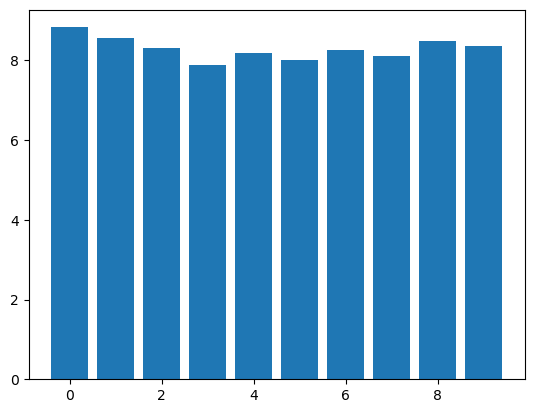

In [6]:
import matplotlib.pyplot as plt

print("Weight norm of each class part of classifier")
print(torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.sqrt(torch.diagonal(torch.mm(head_params[0],head_params[0].transpose(0,1)))).cpu().detach().numpy())

plt.show()

#  HeatMap of weight bias

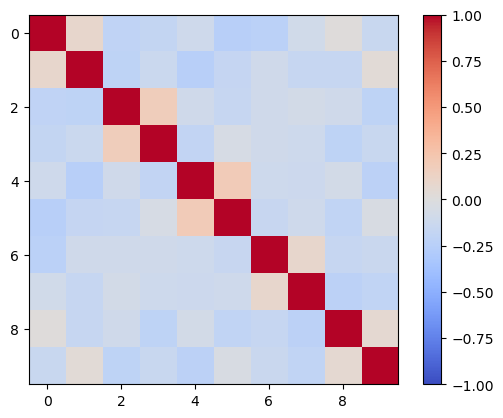

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_classifier, normalized_classifier.transpose(0,1)).cpu().detach().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

# Get a feature centroid vector and each vector's norm and cosine similarity each other (Test Data) 

In [8]:
                model.eval()
                
                label= [i for i in range(num_classes)]
                
                ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
                class_sums = {i: None for i in label}
                class_counts = {i: None for i in label}



                with torch.no_grad():
                    for idx, (images, labels) in enumerate(ldr_test):
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = model.extract_features(images)

                        for i in range(len(label)):
                            class_mask = labels == label[i]  

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                                class_features = features[class_mask]
                                class_sum = class_features.sum(dim=0)
                                count=class_features.shape[0]

                                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                                    class_sums[label[i]]=class_sum
                                    class_counts[label[i]]=count
                                else:
                                    class_sums[label[i]]+=class_sum
                                    class_counts[label[i]]+=count

                #Get the class-wise feature centroid                    
                class_mean_dict={}
                for key, value in class_sums.items():
                    if key in class_counts:
                        class_mean_dict[key] = value / class_counts[key]


                #Get a inner product of centroids

                cos_sim_hist={}

                with torch.no_grad():
                    inner_product_hist={key: 0 for key in class_mean_dict.keys()}
                    for images, labels in ldr_test:
                        images, labels = images.to(args.device), labels.to(args.device)
                        features = model.extract_features(images)
                        for i in range(len(label)):

                            mean_feature=class_mean_dict[label[i]]

                            normalized_mean_feature=mean_feature/torch.norm(mean_feature)

                            class_mask = labels == label[i]  # "cat" 클래스의 마스크를 생성합니다.

                            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 평균 벡터를 계산합니다.
                                class_features = features[class_mask]
                                normalized_class_features=nn.functional.normalize(class_features, p=2, dim=1)

                                inner_product=torch.mm(normalized_class_features, normalized_mean_feature.unsqueeze(1))
                                if label[i] not in cos_sim_hist.keys():
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.array([inner_product.squeeze().cpu().numpy()[()]])
                                    else:
                                        cos_sim_hist[label[i]]=inner_product.squeeze().cpu().numpy()
                                else:
                                    if class_features.shape[0]==1:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], np.array([inner_product.squeeze().cpu().numpy()[()]])), axis=0)

                                    else:
                                        cos_sim_hist[label[i]]=np.concatenate((cos_sim_hist[label[i]], inner_product.squeeze().cpu().numpy()), axis=0)

                                        
                cos_sim_mean={}
                cos_sim_var={}

                for key in class_sums.keys():
                    if key in class_counts:
                        cos_sim_mean[key] = cos_sim_hist[key].mean()
                        cos_sim_var[key] = cos_sim_hist[key].var()
                print("-------------------MEAN-------------------")                

                print(cos_sim_mean)
                print("-------------------VAR-------------------")                

                print(cos_sim_var)



-------------------MEAN-------------------
{0: 0.83023626, 1: 0.8888835, 2: 0.7192478, 3: 0.71578264, 4: 0.76528794, 5: 0.7622343, 6: 0.8000237, 7: 0.8260839, 8: 0.8773742, 9: 0.83339226}
-------------------VAR-------------------
{0: 0.038338907, 1: 0.04097023, 2: 0.047428153, 3: 0.04692385, 4: 0.050869424, 5: 0.04381205, 6: 0.045354232, 7: 0.03239138, 8: 0.041414455, 9: 0.05693001}


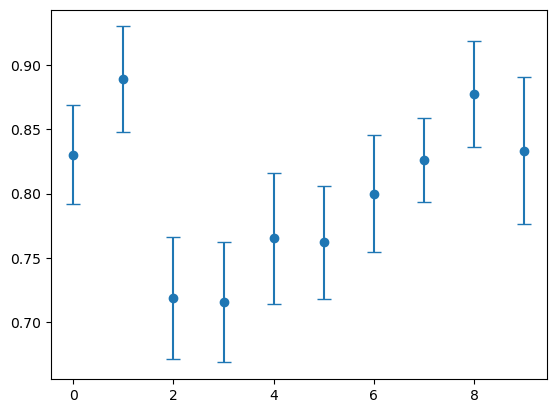

In [9]:
import matplotlib.pyplot as plt


class_index=[i for i in range(num_classes)]

#centroid로부터 cosine similarity 값들의 mean, variance
classwise_mean=list(cos_sim_mean.values())
classwise_var=list(cos_sim_var.values())

plt.errorbar(class_index, classwise_mean, classwise_var, fmt='o', capsize=5)

plt.show()

# Get a feature vector centroid and each centroid vector's norm and cosine similarity each other (Test Data)

In [10]:
model.eval()
label= [i for i in range(num_classes)]                    


ldr_test = DataLoader(dataset_test, batch_size=args.local_bs, shuffle=False)
class_sums = {i: None for i in label}
class_counts = {i: None for i in label}



with torch.no_grad():
    for idx, (images, labels) in enumerate(ldr_test):
        images, labels = images.to(args.device), labels.to(args.device)
        features = model.extract_features(images)

        for i in range(len(label)):
            class_mask = labels == label[i]  

            if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                class_features = features[class_mask]
                class_sum = class_features.sum(dim=0)
                count=class_features.shape[0]

                if class_sums[label[i]]== None and class_counts[label[i]] == None:
                    class_sums[label[i]]=class_sum
                    class_counts[label[i]]=count
                else:
                    class_sums[label[i]]+=class_sum
                    class_counts[label[i]]+=count

#Get the class-wise feature centroid                    
class_mean_dict={}
for key, value in class_sums.items():
    if key in class_counts:
        class_mean_dict[key] = value / class_counts[key]

print(class_mean_dict)
#Get a Inner product of each class's centroid vector

sorted_keys=sorted(class_mean_dict)
print(sorted_keys)

class_mean_lst=[]


for key in sorted_keys:
    class_mean_lst.append(class_mean_dict[key])

class_mean_lst=torch.stack(class_mean_lst)


print(class_mean_lst.shape)
print(class_mean_lst.transpose(0,1).shape)

#Get the each centroid vector's norm
print("-------------Norm of each centroid vectors --------------")
print(torch.diagonal(torch.mm(class_mean_lst, class_mean_lst.transpose(0,1))))


#Get the cosine similarity result between eacn centroid vectors


normalized_class_mean_lst=nn.functional.normalize(class_mean_lst, p=2, dim=1)
print("-------------Cosine similarity of Each Centroid vectors--------------")
print(torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy())

                    
    


{0: tensor([1.0373e-03, 0.0000e+00, 3.9717e-02, 4.7465e-05, 2.9546e-03, 7.1743e-03,
        0.0000e+00, 0.0000e+00, 1.3867e-02, 0.0000e+00, 1.2422e-02, 1.5379e-05,
        1.4310e-01, 0.0000e+00, 0.0000e+00, 1.8858e-03, 5.1152e-03, 0.0000e+00,
        0.0000e+00, 7.3036e-04, 1.8303e-03, 0.0000e+00, 1.5451e-02, 4.3712e-03,
        4.1805e-04, 0.0000e+00, 8.5551e-05, 0.0000e+00, 4.9443e-04, 1.1676e-04,
        7.9929e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.9516e-04, 1.7157e-04,
        2.1479e-03, 0.0000e+00, 1.4211e-04, 2.2900e-03, 1.1859e-01, 0.0000e+00,
        1.3424e-04, 1.0876e-04, 1.3911e-03, 0.0000e+00, 2.1277e-04, 0.0000e+00,
        0.0000e+00, 4.0413e-04, 0.0000e+00, 0.0000e+00, 7.6587e-03, 2.4072e-04,
        1.4528e-01, 0.0000e+00, 0.0000e+00, 3.3206e-03, 0.0000e+00, 0.0000e+00,
        1.1790e-02, 0.0000e+00, 0.0000e+00, 8.1244e-05, 2.2470e-03, 0.0000e+00,
        4.8368e-03, 9.7112e-06, 7.2899e-05, 1.9884e-04, 0.0000e+00, 9.2053e-03,
        0.0000e+00, 0.0000e+00, 0.00

# Cosine Similarity of Centroid Vectors

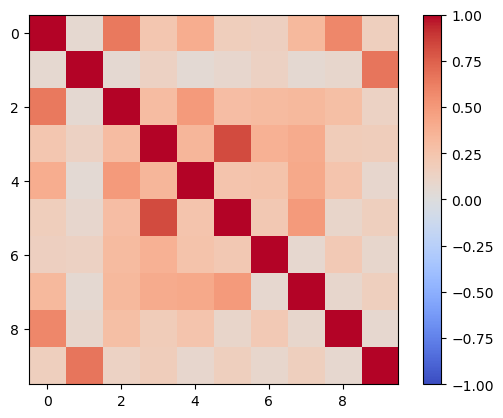

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 2D array로 변환
cos_sim_np = torch.mm(normalized_class_mean_lst, normalized_class_mean_lst.transpose(0,1)).cpu().numpy()
# heatmap 그리기
plt.imshow(cos_sim_np, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.show()

In [12]:
print(type(cos_sim_np))

print(cos_sim_np)

print(cos_sim_np.sum(axis=1))

print(cos_sim_np.sum(axis=0))

<class 'numpy.ndarray'>
[[1.0000001  0.06364918 0.6428894  0.2315998  0.39740053 0.16999078
  0.15279646 0.32374027 0.57875735 0.1590872 ]
 [0.06364918 1.0000001  0.05505266 0.13484125 0.04924767 0.08449307
  0.1397966  0.05813919 0.08804797 0.6622646 ]
 [0.6428894  0.05505266 1.0000002  0.30211678 0.49733266 0.29135484
  0.3062001  0.32200664 0.28254142 0.12670968]
 [0.2315998  0.13484125 0.30211678 1.         0.33877933 0.8271982
  0.3687489  0.40292987 0.1820268  0.17949235]
 [0.39740053 0.04924767 0.49733266 0.33877933 0.9999998  0.24519777
  0.25372538 0.4213592  0.24970874 0.08206197]
 [0.16999078 0.08449307 0.29135484 0.8271982  0.24519777 1.
  0.21186858 0.493478   0.09592563 0.16178443]
 [0.15279646 0.1397966  0.3062001  0.3687489  0.25372538 0.21186858
  0.99999994 0.07539442 0.20636313 0.08690001]
 [0.32374027 0.05813919 0.32200664 0.40292987 0.4213592  0.493478
  0.07539442 0.9999999  0.08651582 0.15830089]
 [0.57875735 0.08804797 0.28254142 0.1820268  0.24970874 0.09592563

# Centroid-Feature Alignment

In [13]:
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

tensor([0.6369, 0.7370, 0.5289, 0.3712, 0.7129, 0.6382, 0.7207, 0.7135, 0.7241,
        0.7206], device='cuda:7', grad_fn=<DiagonalBackward0>)


Centroid-Feature Alignment of each class
tensor([0.6369, 0.7370, 0.5289, 0.3712, 0.7129, 0.6382, 0.7207, 0.7135, 0.7241,
        0.7206], device='cuda:7', grad_fn=<DiagonalBackward0>)


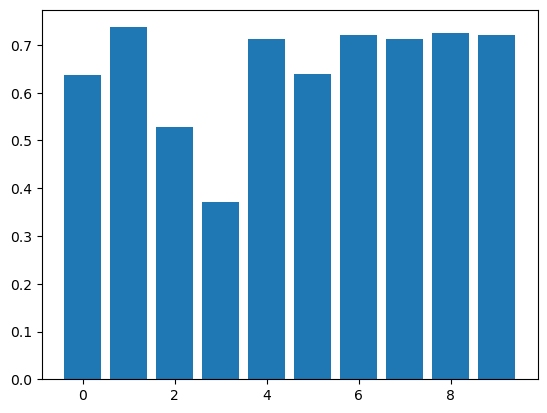

In [14]:
import matplotlib.pyplot as plt

print("Centroid-Feature Alignment of each class")
print(torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))))

class_index=[i for i in range(num_classes)]

plt.bar(class_index, torch.diagonal(torch.mm(normalized_class_mean_lst,normalized_classifier.transpose(0,1))).cpu().detach().numpy())

plt.show()

# Gihun(FedNTD)

In [15]:
    model_key = [name for name, p in model.named_parameters()]
    print(model_key)

['features.0.weight', 'features.0.bias', 'features.3.weight', 'features.3.bias', 'features.6.weight', 'features.6.bias', 'features.8.weight', 'features.8.bias', 'features.11.weight', 'features.11.bias', 'features.13.weight', 'features.13.bias', 'features.16.weight', 'features.16.bias', 'features.18.weight', 'features.18.bias', 'fc.0.weight', 'fc.0.bias', 'fc.2.weight', 'fc.2.bias', 'classifier.weight', 'classifier.bias']


In [16]:
    info_param = [p for name, p in model.named_parameters() if 'fc.2.weight' in name]

    #Get the innerproduct of the classifier part

    print(info_param[0].shape)
    print(len(info_param))


torch.Size([512, 512])
1


In [17]:
print(class_mean_dict[0].shape)

torch.Size([512])


In [18]:
print(torch.transpose(info_param[0], 0, 1)[0].shape)

torch.Size([512])


In [19]:
print(torch.transpose(info_param[0], 0, 1).shape)

torch.Size([512, 512])


In [20]:
list_storage=[]


print(torch.matmul(torch.transpose(info_param[0], 0, 1), class_mean_dict[0]))
print(torch.matmul(torch.transpose(info_param[0], 0, 1), class_mean_dict[0]).shape)


for index in range(10):

    class_info=torch.matmul(torch.transpose(info_param[0], 0, 1), class_mean_dict[index])

    list_storage.append(class_info)
    
print(len(list_storage))    

print(list_storage[0].size())
final= torch.stack((list_storage[0], list_storage[1], list_storage[2], list_storage[3], list_storage[4], list_storage[5], list_storage[6], list_storage[7], list_storage[8], list_storage[9]), dim=0)    


print(final)

print(final.shape)


# 각 행에서 최댓값을 가진 행의 인덱스 추출
max_indices = torch.argmax(final, dim=0).to('cpu').numpy()

print(max_indices)
print(len(max_indices))

tensor([-4.7776e-02, -2.1865e-02,  1.2300e-01, -1.5435e-02, -1.7004e-01,
        -1.2589e-01,  3.8037e-02, -8.2090e-02, -7.3910e-02,  2.7727e-02,
        -3.5563e-02,  1.7430e-03,  4.4195e-03, -1.0311e-01, -3.8704e-03,
        -4.2837e-02,  3.5241e-02, -9.3767e-03,  1.5858e-02,  4.8584e-02,
        -3.3242e-03, -9.3667e-02, -3.5497e-02,  2.0298e-02, -3.6898e-02,
        -4.8686e-03, -3.1858e-02,  8.1540e-02, -4.4186e-02, -2.8216e-02,
        -4.8043e-02, -5.6443e-02, -8.9968e-02,  2.9899e-03,  1.1952e-02,
         8.7372e-02, -3.4674e-02,  7.7493e-03, -1.6795e-02, -3.6575e-02,
         4.8347e-02,  4.0089e-02, -8.9721e-02, -1.2875e-02,  6.3188e-02,
        -5.0937e-02,  2.3767e-02, -2.5562e-02, -6.1969e-03, -1.2828e-02,
        -1.1894e-02, -1.0052e-02, -3.4368e-02,  4.5509e-02, -3.7987e-02,
        -9.0910e-03,  2.7255e-02, -1.1925e-01, -3.6433e-02, -1.1897e-01,
         1.9612e-03,  3.2297e-02, -6.2558e-02, -2.5295e-02, -4.8148e-02,
        -1.8470e-02,  8.4095e-02,  9.4243e-03, -3.3

파이썬의 Matplotlib 라이브러리를 사용하여 10개의 구분 잘되는 색을 추천해 드릴 수 있습니다. 다음은 추천하는 색상 목록입니다:

#1f77b4 (파란색)
#ff7f0e (주황색)
#2ca02c (녹색)
#d62728 (빨간색)
#9467bd (보라색)
#8c564b (갈색)
#e377c2 (분홍색)
#7f7f7f (회색)
#bcbd22 (옐로우)
#17becf (청록색)

In [21]:
color_dict={0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c", 3:"#d62728", 4: "#9467bd", 5: "#8c564b", 6: "#e377c2", 7: "#7f7f7f", 8: "#bcbd22", 9: "#17becf" }

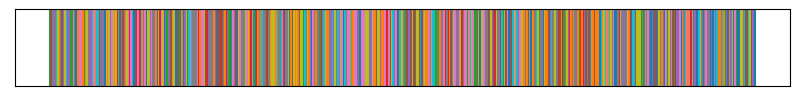

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 1))

for i in range(len(max_indices)):
    plt.plot((i, i), (0, 1), scaley=False, color=color_dict[max_indices[i].item()])

plt.xticks([])  # x축 눈금 숨김
plt.yticks([])  # y축 눈금 숨김

# 그래프를 저장할 디렉토리 경로 설정
save_dir = 'Analysis_figure/ntd/shard2/fn/'

# 그래프 저장
plt.savefig(save_dir + 'DG_default.png')


plt.show()


In [23]:
def find_permutation(lst):
    sorted_indices = sorted(range(len(lst)), key=lambda x: lst[x])
    return sorted_indices

In [24]:
permutation_func = find_permutation(max_indices)
print(permutation_func)

permuted_max_indices= [max_indices[i] for i in permutation_func]

[19, 40, 61, 66, 70, 78, 83, 91, 92, 95, 97, 121, 131, 136, 149, 174, 190, 213, 225, 252, 270, 312, 333, 347, 349, 358, 399, 410, 411, 422, 436, 438, 441, 446, 458, 469, 470, 474, 479, 481, 492, 496, 499, 500, 511, 7, 20, 21, 24, 26, 33, 42, 47, 55, 67, 77, 89, 96, 109, 119, 127, 145, 151, 153, 160, 164, 175, 178, 180, 188, 193, 201, 202, 218, 220, 236, 241, 242, 271, 273, 274, 283, 290, 344, 346, 348, 350, 351, 360, 361, 371, 378, 380, 383, 386, 394, 396, 397, 398, 401, 405, 420, 444, 459, 463, 485, 486, 489, 493, 0, 15, 16, 25, 85, 94, 100, 130, 132, 148, 184, 196, 258, 280, 282, 303, 308, 309, 329, 355, 373, 384, 392, 429, 431, 448, 453, 467, 490, 498, 49, 58, 63, 65, 80, 108, 114, 124, 128, 146, 150, 158, 197, 244, 245, 287, 289, 299, 323, 369, 372, 377, 385, 387, 413, 421, 454, 465, 2, 4, 10, 13, 14, 29, 30, 38, 44, 54, 68, 73, 76, 84, 86, 98, 116, 120, 129, 134, 171, 189, 195, 198, 204, 206, 210, 223, 233, 240, 250, 260, 261, 276, 284, 292, 295, 316, 321, 326, 340, 356, 363, 376,

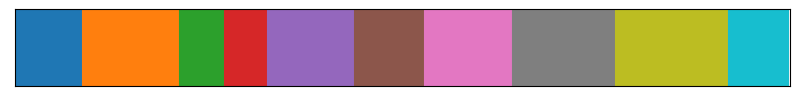

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 1))

for i in range(len(max_indices)):
    plt.plot((i, i), (0, 1), scaley=False, color=color_dict[permuted_max_indices[i].item()])
plt.xlim(0, len(max_indices))
plt.xticks([])  # x축 눈금 숨김
plt.yticks([])  # y축 눈금 숨김

# 그래프를 저장할 디렉토리 경로 설정
save_dir = 'Analysis_figure/ntd/shard2/fn/'

# 그래프 저장
plt.savefig(save_dir + 'DG.png')


plt.show()


# Generate Local Model

In [26]:
def get_class_mean_dict(model, num_classes, dataset_test, args):

    model.eval()
    label= [i for i in range(num_classes)]                    


    ldr_test = DataLoader(dataset_test, batch_size=args.bs, shuffle=False)
    class_sums = {i: None for i in label}
    class_counts = {i: None for i in label}



    with torch.no_grad():
        for idx, (images, labels) in enumerate(ldr_test):
            images, labels = images.to(args.device), labels.to(args.device)
            features = model.extract_features(images)

            for i in range(len(label)):
                class_mask = labels == label[i]  

                if class_mask.any():  # 클래스에 속하는 데이터가 있는 경우에만 해당
                    class_features = features[class_mask]
                    class_sum = class_features.sum(dim=0)
                    count=class_features.shape[0]

                    if class_sums[label[i]]== None and class_counts[label[i]] == None:
                        class_sums[label[i]]=class_sum
                        class_counts[label[i]]=count
                    else:
                        class_sums[label[i]]+=class_sum
                        class_counts[label[i]]+=count

    #Get the class-wise feature centroid                    
    class_mean_dict={}
    for key, value in class_sums.items():
        if key in class_counts:
            class_mean_dict[key] = value / class_counts[key]
            
    return class_mean_dict


In [27]:
def get_local_figure(info_param, class_mean_dict, local_index):

    list_storage=[]



    for index in range(10):

        class_info=torch.matmul(torch.transpose(info_param[0], 0, 1), class_mean_dict[index])

        list_storage.append(class_info)


    final= torch.stack((list_storage[0], list_storage[1], list_storage[2], list_storage[3], list_storage[4], list_storage[5], list_storage[6], list_storage[7], list_storage[8], list_storage[9]), dim=0)    

    # 각 행에서 최댓값을 가진 행의 인덱스 추출
    max_indices = torch.argmax(final, dim=0).to('cpu').numpy()

    permuted_max_indices= [max_indices[i] for i in permutation_func]


    if local_index%10==0:
        plt.figure(figsize=(10, 1))

        for i in range(len(max_indices)):
            plt.plot((i, i), (0, 1), scaley=False, color=color_dict[permuted_max_indices[i].item()])
        plt.xlim(0, len(max_indices))
        plt.xticks([])  # x축 눈금 숨김
        plt.yticks([])  # y축 눈금 숨김

        # 그래프를 저장할 디렉토리 경로 설정
        save_dir = 'Analysis_figure/ntd/shard2/fn/'

        # 그래프 저장
        plt.savefig(save_dir + 'Local_{}.png'.format(local_index))


In [28]:
def get_aggregated_figure(info_param, class_mean_dict):

    list_storage=[]



    for index in range(10):

        class_info=torch.matmul(torch.transpose(info_param[0], 0, 1), class_mean_dict[index])

        list_storage.append(class_info)


    final= torch.stack((list_storage[0], list_storage[1], list_storage[2], list_storage[3], list_storage[4], list_storage[5], list_storage[6], list_storage[7], list_storage[8], list_storage[9]), dim=0)    

    # 각 행에서 최댓값을 가진 행의 인덱스 추출
    max_indices = torch.argmax(final, dim=0).to('cpu').numpy()

    permuted_max_indices= [max_indices[i] for i in permutation_func]



    plt.figure(figsize=(10, 1))

    for i in range(len(max_indices)):
        plt.plot((i, i), (0, 1), scaley=False, color=color_dict[permuted_max_indices[i].item()])
    plt.xlim(0, len(max_indices))
    plt.xticks([])  # x축 눈금 숨김
    plt.yticks([])  # y축 눈금 숨김

    # 그래프를 저장할 디렉토리 경로 설정
    save_dir = 'Analysis_figure/ntd/shard2/fn/'

    # 그래프 저장
    plt.savefig(save_dir + 'AG.png')


Files already downloaded and verified
Files already downloaded and verified
-----------------------------------------------------
Client: 0
82.0
After
98.0
-----------------------------------------------------
Client: 1
88.0
After
96.0
-----------------------------------------------------
Client: 2
77.0
After
97.0
-----------------------------------------------------
Client: 3
86.0
After
96.0
-----------------------------------------------------
Client: 4
85.0
After
100.0
-----------------------------------------------------
Client: 5
87.0
After
98.0
-----------------------------------------------------
Client: 6
79.0
After
96.0
-----------------------------------------------------
Client: 7
91.0
After
98.0
-----------------------------------------------------
Client: 8
80.0
After
98.0
-----------------------------------------------------
Client: 9
85.0
After
96.0
-----------------------------------------------------
Client: 10
81.0
After
95.0
------------------------------------------

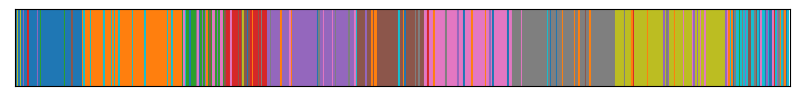

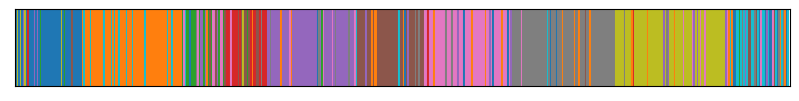

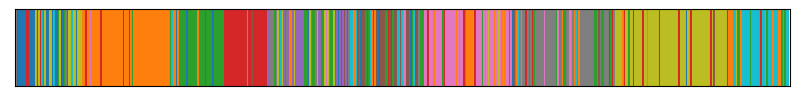

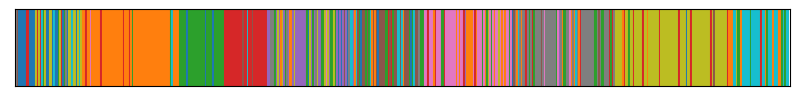

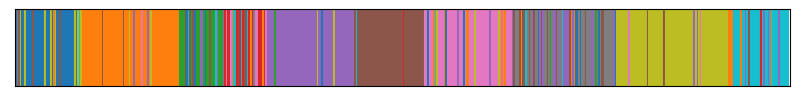

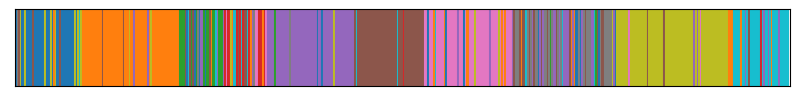

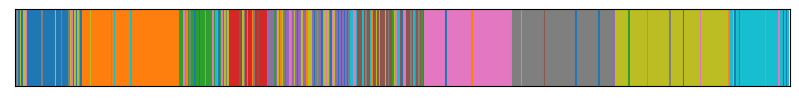

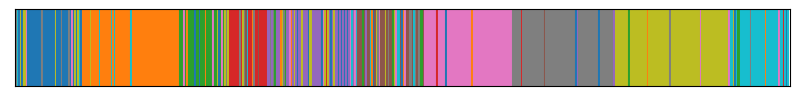

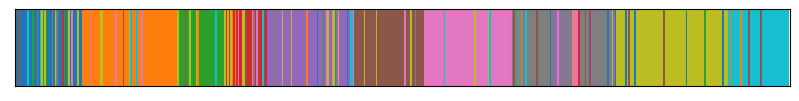

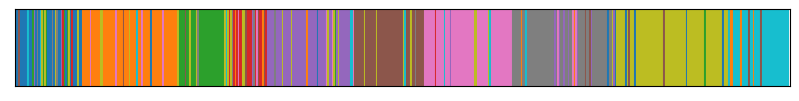

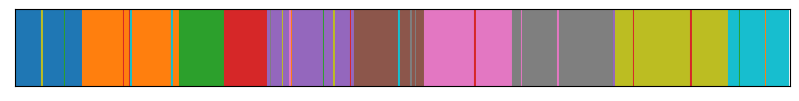

In [29]:
model = 'vgg' # cnn, mobile
dataset = 'cifar10' # cifar10, cifar100 
num_classes = 10 # 10, 100
momentum = 0.90
wd = 1e-5
server_data_ratio=0.0


for shard_per_user in [2]:
    for frac in [0.1]:
        for local_ep in [15]:
            for local_upt_part, aggr_part in [('full', 'full')]:
                args = easydict.EasyDict({'epochs': local_ep,
                                          'num_users': 100,
                                          'shard_per_user': shard_per_user,
                                          'server_data_ratio': server_data_ratio,
                                          'frac': frac,
                                          'local_ep': local_ep,
                                          'local_bs': 500,
                                          'bs': 50,
                                          'lr': 0.03,
                                          'momentum': momentum,
                                          'wd': wd,
                                          'model': model,
                                          

                                          'dataset': dataset,
                                          'iid': False,
                                          'num_classes': num_classes,
                                          'gpu': 7,
                                          'verbose': False,
                                          'seed': 1,
                                          'test_freq': 1,
                                          'load_fed': '',
                                          'results_save': 'run1',
                                          'local_upt_part': local_upt_part,
                                          'aggr_part': aggr_part,
                                          'feature_norm': 1,
                                          'fn': True,
                                          'hetero_option': "shard"
                                          })

                # parse args
                args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')
                base_dir = './save/full_and_body/{}_iid{}_num{}_C{}_le{}_m{}_wd{}_round_320/shard{}_new/decay_0.1/fn_{}/seed_0/norm_{}/FedAvg'.format(
                    args.model, args.iid, args.num_users, args.frac, args.local_ep, args.momentum, args.wd,args.shard_per_user, args.fn, args.feature_norm)
                algo_dir = 'local_upt_{}_lr_{}'.format(args.local_upt_part, args.lr)


                dataset_train, dataset_test, dict_users_train, dict_users_test = get_data(args)
                dict_save_path = 'setting_3.pkl'
                with open(dict_save_path, 'rb') as handle:#기존 pretrained되었을 때 쓰였던 클라이언트 구성으로 덮어씌운다.
                    dict_users_train, dict_users_test = pickle.load(handle)

                # build model
                net_glob = get_model(args)
                net_glob.train()

                net_local_list = []
                for user_ix in range(args.num_users):
                    net_local_list.append(copy.deepcopy(net_glob))

                criterion = nn.CrossEntropyLoss()

                before_acc_results = []#pretrained 모델에서의 모든 각 클라이언트의 test acc 기록!!
                after_acc_results = []

                w_glob = None
                data_size=[]

                for user, net_local in enumerate(net_local_list):
                    model_save_path = os.path.join(base_dir, algo_dir, 'best_model.pt')#pretrained된 중앙모델 업로드!!
                    net_local.load_state_dict(torch.load(model_save_path, map_location=args.device), strict=True)
                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    before_acc_results.append(acc_test)

                    print ("-----------------------------------------------------")
                    print ("Client: {}".format(user))

                    print(acc_test)

                    net_local.train()
                    ldr_train = DataLoader(DatasetSplit(dataset_train, dict_users_train[user]), batch_size=args.bs, shuffle=True)

                    body_params = [p for name, p in net_local.named_parameters() if 'classifier' not in name]
                    head_params = [p for name, p in net_local.named_parameters() if 'classifier' in name]
                    optimizer = torch.optim.SGD([{'params': body_params, 'lr': 0.0003},
                                                 {'params': head_params, 'lr': 0.0003}],
                                                momentum=args.momentum, weight_decay=args.wd)#full update!!

                    for iter in range(args.local_ep):
                        for batch_idx, (images, labels) in enumerate(ldr_train):
                            images, labels = images.to(args.device), labels.to(args.device)
                            net_local.zero_grad()
                            logits = net_local(images)

                            loss = criterion(logits, labels)
                            loss.backward()
                            optimizer.step()

                    acc_test, loss_test = test_img_local(net_local, dataset_test, args, user_idx=user, idxs=dict_users_test[user])
                    after_acc_results.append(acc_test)#pretrain 이후의 personalized accuracy 기재!!
                    print('After')
                    print(acc_test)


                    #Get a Local Model figure

                    class_mean_dict=get_class_mean_dict(net_local, num_classes, dataset_test, args)
                    info_param = [p for name, p in net_local.named_parameters() if 'fc.2.weight' in name]

                    get_local_figure(info_param, class_mean_dict, user)


                    train_size=len(dict_users_train[user])

                    data_size.append(train_size)

                    if w_glob is None:
                        w_glob = copy.deepcopy(net_local.state_dict())
                    else:
                        for k in w_glob.keys():
                            w_glob[k] += net_local.state_dict()[k]

                # Aggregation
                for k in w_glob.keys():
                    w_glob[k] = torch.div(w_glob[k], args.num_users)

                agg_net= get_model(args)   

                agg_net.load_state_dict(w_glob)    
                class_mean_dict=get_class_mean_dict(agg_net, num_classes, dataset_test, args)
                info_param = [p for name, p in agg_net.named_parameters() if 'fc.2.weight' in name]



                get_aggregated_figure(info_param, class_mean_dict)                
                agg_accuracy, agg_test_loss =test_img_global(agg_net, dataset_test, args)
                print ("-----------------------------------------------------")
                print ("local update part: {}, aggregation part: {}".format(local_upt_part, aggr_part))
                print ("iid, frac: {}, local_ep: {}".format(frac, local_ep))
                print ("Before min/max/mean/std of accuracy")
                print (np.min(before_acc_results), np.max(before_acc_results), np.mean(before_acc_results), round(np.std(before_acc_results), 2))
                print ("After min/max/mean/std of accuracy")
                print (np.min(after_acc_results), np.max(after_acc_results), np.mean(after_acc_results), round(np.std(after_acc_results), 2))
                print ("-----------------------------------------------------")

                print ("Accuracy of Aggregated Model")
                print (agg_accuracy)
                print ("-----------------------------------------------------")            